In [ ]:
!pip install numpy scipy matplotlib scikit-learn seaborn cvxopt pywavelets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import cvxopt
import seaborn as sns
import pywt
import os
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
path='/content/drive/MyDrive/DatasetP2/'

Mounted at /content/drive/


In [ ]:
import librosa
import matplotlib.pylab as plt
from IPython.display import Audio
y,sr=librosa.load(path+"testing/Positive/1066_Positive_male_23.wav")
mfccs=librosa.feature.mfcc(y=y,sr=sr)
feature_vectore=np.array(mfccs.mean(axis=1))
print("Feature vector of postives cough: ", feature_vectore)
print("vector dimension: ",feature_vectore.shape)
Audio(data=y, rate=sr)

Feature vector of postives cough:  [-300.85138     76.66731    -14.7407255   22.658392   -22.026133
   14.392492   -36.612614    -7.316286   -35.427242   -29.252478
   -8.422719   -11.7088785   -2.4408855  -24.00735     -3.5996087
  -11.310632    -7.5129504   -9.307525    -4.9801598   -8.948799 ]
vector dimension:  (20,)


 Podemos ver que la data no es separable ni en 2D ni en 3D mediante ploteando la data

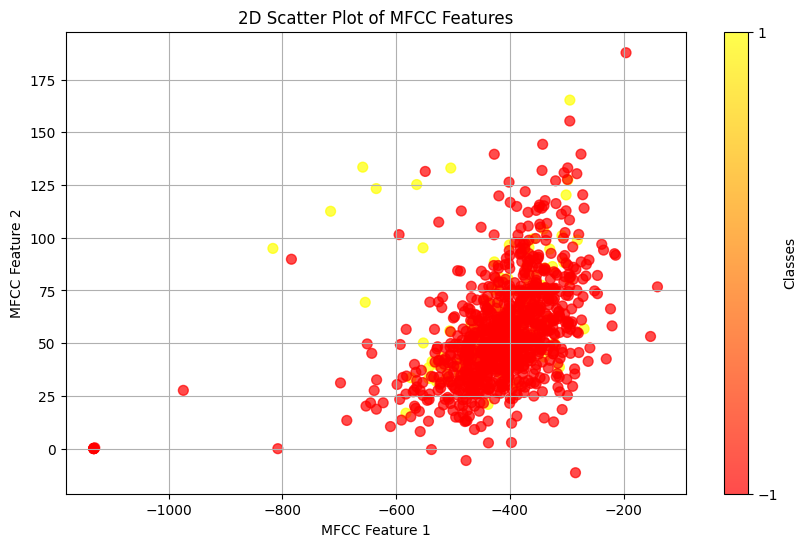

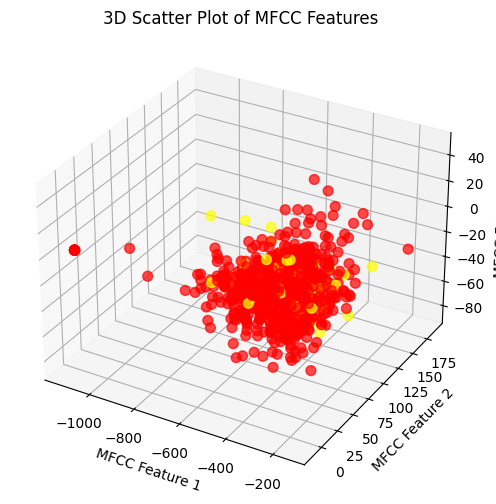

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os

def encode(path, data_type='training'):
    data1 = []
    labels1 = []

    #directory_1 para los covid clasificados como positivos
    directory_1 = os.listdir(path + data_type + "/Positive")
    for f in directory_1:
        y, sr = librosa.load(path + data_type + "/Positive/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1) #promedio de los coeficientes de cada dimensión
        data1.append(fv)
        labels1.append(1)#label para positive=1


    directory_2 = os.listdir(path + data_type + "/Negative")
    for f in directory_2: #para covid=negativo
        y, sr = librosa.load(path + data_type + "/Negative/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data1.append(fv) #agrego el promedio de los coeficientes de cada dimensión
        labels1.append(-1)  #label para negative=-1


    data = np.array(data1)
    labels = np.array(labels1)

    return data, labels

# cargo la data
Xp, yp = encode(path)

# ploteo en 2d para ver distribución de datos
def plot_2d(X, y):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn', alpha=0.7)
    plt.title("2D Scatter Plot of MFCC Features")
    plt.xlabel("MFCC Feature 1") #feature 1 es el promedio de los coeficientes de la primera dimensión
    plt.ylabel("MFCC Feature 2") #feature 2 es el promedio de los coeficientes de la segunda dimensión
    plt.colorbar(scatter, ticks=[-1, 1], label='Classes') 
    #como es SVM, las clases son 1 y -1
    plt.grid()
    plt.show()

# ploteo en 3d para ver distribución de data
def plot_3d(X, y):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], c=y, s=50, cmap='autumn', alpha=0.7)
    ax.set_title("3D Scatter Plot of MFCC Features")
    ax.set_xlabel("MFCC Feature 1")
    ax.set_ylabel("MFCC Feature 2")
    ax.set_zlabel("MFCC Feature 3") #son 3 dimensiones
    plt.show()

plot_2d(Xp, yp)
if Xp.shape[1] >= 3:
    plot_3d(Xp, yp)
else:
    print("Not enough dimensions for 3D plotting.")


* **Podemos ver que la data no se encuentra balanceada y con dificultad para dividirla en 2 clases distintas debido a que la cantidad de datos pertenecientes a la clase de negativos predomina enormemente la clase de postivos a covid-19. Ante ello, disminuiré la cantidad de elementos en "negative" para que así no haya un desbalance al momento de clasificar la tos de del dataset para tener un equilibrio en los datos**

In [ ]:
import numpy as np
import os
from sklearn.utils import resample  
# Import resample para downsampling negativos

def encode(path, data_type='training'):
    data1 = []
    directory_1 = os.listdir(path + data_type + "/Positive")
    print("Positive files:", directory_1)
    for f in directory_1:
        y, sr = librosa.load(path + data_type + "/Positive/" + f)
        #librosa para extraer los coeficientes mfcc
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        #con mfccs.mean(axis=1) se obtiene el promedio de los coeficientes de cada archivo
        fv = mfccs.mean(axis=1)
        data1.append(fv)

    data = np.array(data1)
    data = np.insert(data, 0, -1, axis=1)

    data2 = []
    directory_2 = os.listdir(path + data_type + "/Negative")
    print("Negative files:", directory_2)
    for f in directory_2:
        y, sr = librosa.load(path + data_type + "/Negative/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data2.append(fv)

    temp = np.array(data2)
    temp = np.insert(temp, 0, 1, axis=1)

    data = np.concatenate((data, temp), axis=0)
    np.random.shuffle(data)
    y = data[:, 0] # etiquetas
    x = data[:, 1:] # datos
    positive_samples = x[y == -1]
    negative_samples = x[y == 1]

    # bajo la cantidad de samples negativos hasta que sea la misma de positivos
    negative_samples_downsampled = resample(negative_samples,replace=False, n_samples=len(positive_samples),random_state=42)

    x_downsampled = np.vstack([positive_samples, negative_samples_downsampled])
    # x_downsampled me da los datos con la misma cantidad de positivos y negativos
    y_downsampled = np.hstack([np.ones(len(positive_samples)), -1 * np.ones(len(negative_samples_downsampled))])
    #y_downsampled me da las etiquetas de los datos con la misma cantidad de positivos y negativos
    shuffled_indices = np.random.permutation(len(x_downsampled)) 
    x_downsampled = x_downsampled[shuffled_indices]
    y_downsampled = y_downsampled[shuffled_indices]

    return x_downsampled, y_downsampled

x_train, y_train = encode(path)
x_test, y_test = encode(path, 'testing')


Positive files: ['1358_Positive_male_25.wav', '1341_Positive_female_20.wav', '1502_Positive_male_34.mp3', '1377_Positive_male_34.wav', '132_Positive_female_25.wav', '1503_Positive_male_93.mp3', '1501_Positive_male_434.mp3', '1500_Positive_male_12.mp3', '1410_Positive_male_25.wav', '1503_Positive_male_345.mp3', '1332_Positive_male_2.wav', '1412_Positive_male_29.wav', '1523_Positive_male_92 (3).mp3', '1521_Positive_male_98 (28).mp3', '1521_Positive_male_98 (25).mp3', '1521_Positive_male_98 (24).mp3', '1522_Positive_male_98 (2).mp3', '1523_Positive_male_92 (1).mp3', '1524_Postive_male_356 (1).wav', '1521_Positive_male_98 (11).mp3', '1522_Positive_male_98.mp3', '1521_Positive_male_98 (20).mp3', '1521_Positive_male_98 (17).mp3', '1521_Positive_male_98 (23).mp3', '1521_Positive_male_98 (19).mp3', '1523_Positive_male_92 (4).mp3', '1521_Positive_male_98 (12).mp3', '1523_Positive_male_92 (5).mp3', '1521_Positive_male_98 (15).mp3', '1521_Positive_male_98 (26).mp3', '1521_Positive_male_98 (21).mp

data train y test
Se ha dividido la data en 70% training y 30% testing
https://drive.google.com/drive/folders/1xghbOFVuSlWvO9MTukntA_G57kYnM8gj?usp=sharing

In [ ]:
x_train,y_train = encode(path)
x_test, y_test=encode(path, 'testing')

Positive files: ['1358_Positive_male_25.wav', '1341_Positive_female_20.wav', '1502_Positive_male_34.mp3', '1377_Positive_male_34.wav', '132_Positive_female_25.wav', '1503_Positive_male_93.mp3', '1501_Positive_male_434.mp3', '1500_Positive_male_12.mp3', '1410_Positive_male_25.wav', '1503_Positive_male_345.mp3', '1332_Positive_male_2.wav', '1412_Positive_male_29.wav', '1523_Positive_male_92 (3).mp3', '1521_Positive_male_98 (28).mp3', '1521_Positive_male_98 (25).mp3', '1521_Positive_male_98 (24).mp3', '1522_Positive_male_98 (2).mp3', '1523_Positive_male_92 (1).mp3', '1524_Postive_male_356 (1).wav', '1521_Positive_male_98 (11).mp3', '1522_Positive_male_98.mp3', '1521_Positive_male_98 (20).mp3', '1521_Positive_male_98 (17).mp3', '1521_Positive_male_98 (23).mp3', '1521_Positive_male_98 (19).mp3', '1523_Positive_male_92 (4).mp3', '1521_Positive_male_98 (12).mp3', '1523_Positive_male_92 (5).mp3', '1521_Positive_male_98 (15).mp3', '1521_Positive_male_98 (26).mp3', '1521_Positive_male_98 (21).mp

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def matriz_confusion(y_pred, y_test, Tipo):

    matrix = confusion_matrix(y_test, y_pred)

    #normalizo
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis],
                      index=["Negative", 'Positive'],
                      columns=["Negative", 'Positive'])

    # heatmap para visualizar la matriz de confusion
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix " + Tipo)
    plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()


# **SVM: Suppport Vector machine**

0. Normalización

In [ ]:
from sklearn.preprocessing import RobustScaler

def normalizacion_svm(data):
    scaler = RobustScaler() 
    #robust scaler para escalar la data
    data = data.reshape(-1, 1)
    data = scaler.fit_transform(data)
    return data.ravel()

### 1. Hypothesis:

$h(x_i) = x_i*w^t + b$

In [ ]:
def h_svm(X,w,b):
  return np.dot(X,w.T) + b

### 2. Loss function

$L = \frac{1}{2}\parallel W \parallel_2^2  + C\sum_{i=0}^nmax(0,1-y_i(x_iw^t + b)) $


In [ ]:
def loss_svm(y,y_aprox,W,C):
    L = (1/2)*np.linalg.norm(W)**2 + C*np.sum(np.maximum(0,1-y*y_aprox))
    return L

### 3. Derivatives

1. iF ($y_i*h(x_i)) \lt 1 $
 - $\frac{\partial L}{\partial w} = w + C\sum_{
 i=0}^n-y_i*x_i $
2. else
 - $\frac{\partial L}{\partial w} = w $

In [ ]:
def derivatives_svm(x, y, y_aprox, w, b, C):
    condition = y * y_aprox

    mask = condition < 1
    dw = w + C * np.sum((-y[mask, np.newaxis] * x[mask]), axis=0)

    db = C * np.sum(-y[mask])

    return db, dw

### 4. Update Parameters


1. iF ($y_i*h(x_i)) \lt 1 $
 - $w  = w -  \alpha( C\sum_{
 i=0}^n-y_i*x_i) $
2. else
 - $w = w -  \alpha*w$

In [ ]:
def Update_svm(x,y,y_aprox,w, b, db, dw, alpha,C):
  if (np.dot(y_aprox,h_svm(x,w,b))<1):
    w=w-alpha*(C*np.dot(-y_aprox,x))
  else:
    w=w-alpha*dw
  b=b-alpha*db
  return w, b

5. Training stage

In [ ]:
def training_svm(X, Y, C, alpha, epochs):
  w = np.array([np.random.rand() for i in range(X.shape[1])])
  b = np.random.rand()
  error = []
  for i in range(epochs):
    Y_aprox = h_svm(X,w,b)
    db, dw = derivatives_svm(X, Y,Y_aprox, w, b, C)
    w, b = Update_svm(X,Y,Y_aprox,w, b, db, dw, alpha,C)
    L = loss_svm(Y,Y_aprox,w,C)
    error.append(L)
  return w, b, error



testing

In [ ]:
def predict_svm(X,W,b):
  y_aprox = []
  for i in range(X.shape[0]):
    prediction=(np.sign(np.dot(X[i], W.transpose())+b))
    y_aprox.append(prediction)
  return np.array(y_aprox)

In [ ]:
m = y_train.size
k = x_train[0].size
x_train_norm = np.apply_along_axis(normalizacion_svm, 1, x_train)
x_test_norm = np.apply_along_axis(normalizacion_svm, 1, x_test)

x_train_norm = np.insert(x_train_norm, 0, 1, axis=1)
x_test_norm = np.insert(x_test_norm, 0, 1, axis=1)

W, b, e1, = training_svm(x_train_norm, y_train, 1e6, 1e-8, 5000) #C=1e6, alpha=1e-8 y ephocs= 5000
m = y_test.size
y_pred = predict_svm(x_test_norm, W, b)
y_test = y_test.astype('int')
correct=np.count_nonzero(y_pred == y_test) #cuento los -1  o 1 y comparo con el test

print("Clasificados correctamente:", correct)
print("Clasificados incorrectamente:", len(y_test)-correct)
print("% de efectividad", round(100*correct/len(y_test), 2))

Clasificados correctamente: 53
Clasificados incorrectamente: 37
% de efectividad 58.89


# **Matriz de confusion: SVM**

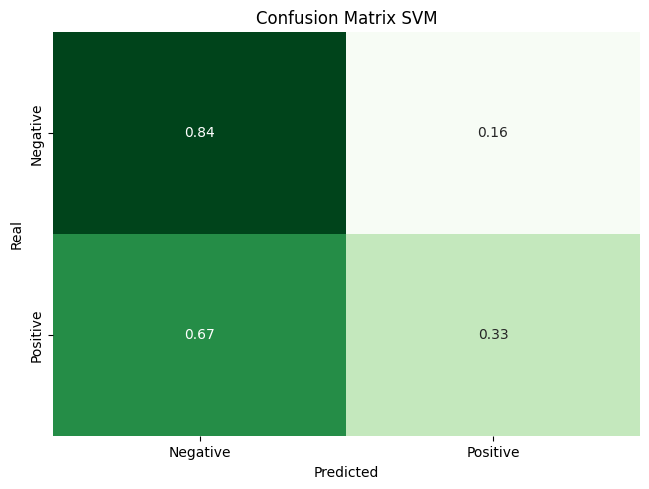

In [ ]:

matriz_confusion(y_pred, y_test, "SVM")


# **Precision, recall y f1-score: SVM**

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, target_names = ["Negative", "Positive"])
print(" My Model Metrics  ")
print(report)

 My Model Metrics  
              precision    recall  f1-score   support

    Negative       0.56      0.84      0.67        45
    Positive       0.68      0.33      0.45        45

    accuracy                           0.59        90
   macro avg       0.62      0.59      0.56        90
weighted avg       0.62      0.59      0.56        90



* **Ante el cambio de longitudes, hemos logrado un f1 score de 0.65 para valores negative y 0.61 para valores de positive con un accuracy final de 0.59**


# **K-fold cross validation: SVM**
 (referencia medium k-fold )
https://medium.com/@avijit.bhattacharjee1996/implementing-k-fold-cross-validation-from-scratch-in-python-ae413b41c80d

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score


def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds


def k_fold_cross_validation_svm(X, y, k, C, alpha, epochs):
    fold_indices = kfold_indices(X, k)
    scores = []

    for train_indices, test_indices in fold_indices:

        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]
        #obtengo su norma de train y test
        X_train_norm = np.apply_along_axis(normalizacion_svm, 1, X_train)
        X_test_norm = np.apply_along_axis(normalizacion_svm, 1, X_test)

        X_train_norm = np.insert(X_train_norm, 0, 1, axis=1)
        X_test_norm = np.insert(X_test_norm, 0, 1, axis=1)

        #le mando los x_train y y_train del training del svm
        W, b, _ = training_svm(X_train_norm, y_train, C, alpha, epochs)
        y_pred = predict_svm(X_test_norm, W, b)
        fold_score = accuracy_score(y_test, y_pred) #score
        scores.append(fold_score)

    mean_accuracy = np.mean(scores)
    return scores, mean_accuracy
#preubo para diferentes ks cuál es el mejor k-cross validtation
listak=[]
listaaccuracy=[]
for i in range(5, 10):
  k = i  #
  listak.append(k)
  C = 1e6
  alpha = 1e-8
  epochs = 5000


  scores, mean_accuracy = k_fold_cross_validation_svm(x_train, y_train, k, C, alpha, epochs)
  listaaccuracy.append(mean_accuracy)
  print("K= ", i)
  print("K-Fold Cross-Validation Scores:", scores)
  print("Mean Accuracy:", mean_accuracy)


K=  5
K-Fold Cross-Validation Scores: [0.5, 0.5476190476190477, 0.38095238095238093, 0.6190476190476191, 0.47619047619047616]
Mean Accuracy: 0.5047619047619047
K=  6
K-Fold Cross-Validation Scores: [0.5428571428571428, 0.45714285714285713, 0.6, 0.5142857142857142, 0.5428571428571428, 0.5714285714285714]
Mean Accuracy: 0.5380952380952381
K=  7
K-Fold Cross-Validation Scores: [0.5666666666666667, 0.36666666666666664, 0.5, 0.5, 0.6666666666666666, 0.6, 0.6]
Mean Accuracy: 0.5428571428571429
K=  8
K-Fold Cross-Validation Scores: [0.6538461538461539, 0.38461538461538464, 0.46153846153846156, 0.46153846153846156, 0.5769230769230769, 0.5769230769230769, 0.5384615384615384, 0.4230769230769231]
Mean Accuracy: 0.5096153846153846
K=  9
K-Fold Cross-Validation Scores: [0.6086956521739131, 0.4782608695652174, 0.5217391304347826, 0.6086956521739131, 0.6086956521739131, 0.5652173913043478, 0.6956521739130435, 0.6086956521739131, 0.4782608695652174]
Mean Accuracy: 0.5748792270531401


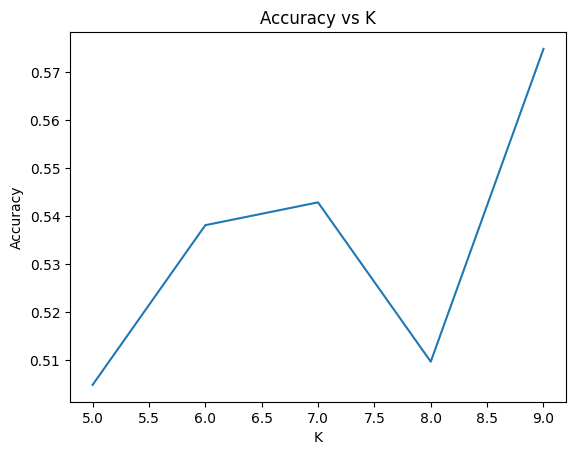

In [ ]:
import matplotlib.pyplot as plt

plt.plot(listak, listaaccuracy)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.show()

* **Podemos ver que el acurracy que nos brinda k-fold con SVM es de máximo 0.57 con K=9**

## **Bootstrap usando scipy**

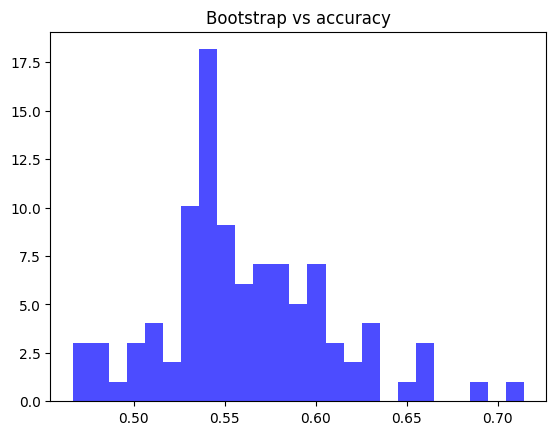

[0.48571429 0.65261905]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap #uso scipy para bootstrap

#evalua mi modelo mandandole training y predict
def model(X, y, C, alpha, epochs):
    X_norm = np.apply_along_axis(normalizacion_svm, 1, X)
    X_norm = np.insert(X_norm, 0, 1, axis=1)
    W, b, _ = training_svm(X_norm, y, C, alpha, epochs) #1.training
    y_pred = predict_svm(X_norm, W, b)#2. predirct
    accuracy = np.mean(y_pred == y) #el acurracy lo saco con el promedio de ypred vs y
    return accuracy

def bootstrap_accuracy(X, y, n_iterations, C, alpha, epochs):
    listaaccuracies = []
    for _ in range(n_iterations):
        # tomo randoms de x, y
        indices = np.random.choice(len(y), size=len(y), replace=True)
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        # mido el acurracy con randoms del X_bootstrap y y_bootstrap
        accuracy = model(X_bootstrap, y_bootstrap, C, alpha, epochs)
        listaaccuracies.append(accuracy)
    return np.array(listaaccuracies)

n_iterations = 100
C = 1e6
alpha = 1e-8
epochs = 5000  #mismo num de epoch

bootstrap_results = bootstrap_accuracy(x_train, y_train, n_iterations, C, alpha, epochs)
fig, ax = plt.subplots()
ax.hist(bootstrap_results, bins=25, density=True, alpha=0.7, color='blue')
ax.set_title('Bootstrap vs accuracy')
plt.show()


conf_int = np.percentile(bootstrap_results, [5, 95])
print( conf_int)


# **Regresión Logística**

In [ ]:
import numpy as np
import os
import librosa
from imblearn.over_sampling import BorderlineSMOTE


def encode(path, data_type='training'):
    data1 = []

    #para positivis
    directory_1 = os.listdir(path + data_type + "/Positive")
    print("Positive files:", directory_1)

    for f in directory_1:
        y, sr = librosa.load(path + data_type + "/Positive/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data1.append(fv)

    data = np.array(data1)
    data = np.insert(data, 0, 1, axis=1)  # Positive= 1

    data2 = []


    directory_2 = os.listdir(path + data_type + "/Negative")
    print("Negative files:", directory_2)

    for f in directory_2:
        y, sr = librosa.load(path + data_type + "/Negative/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        data2.append(fv)

    temp = np.array(data2)
    temp = np.insert(temp, 0, 0, axis=1)  # Negative= 0 en logidtica

    data = np.concatenate((data, temp), axis=0)
    np.random.shuffle(data)
    y = data[:, 0]
    x = data[:, 1:]

    return x, y


def borderline_smote(x_train, y_train):
  #bordeline smote ayuda a que la data se divida priorizando la clase minoritaria
    bs = BorderlineSMOTE(sampling_strategy='minority', kind='borderline-1')
    x_resampled, y_resampled = bs.fit_resample(x_train, y_train)
    return x_resampled, y_resampled



In [ ]:
def sigmoid_log(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
def derivatives_log(X, y, w, b):
    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid_log(np.dot(X[i], w) + b)
        err_i = f_wb_i - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i, j]
        dj_db = dj_db + err_i
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [ ]:
def cost_log_with_l2(X, y, w, b, pos_weight=60, lambda_l2=0.001):
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = sigmoid_log(z_i)

        if y[i] == 1:
            #si y=1 (positive, tendrá un peso adicional ya que es la clase minoritaria)
            cost += -pos_weight * y[i] * np.log(f_wb_i + 1e-8)
        else:
            cost += -(1 - y[i]) * np.log(1 - f_wb_i + 1e-8)

    #Se utilizo regularización L2 para equilibrar
    cost += lambda_l2 * np.sum(w ** 2) / (2 * m)

    return cost

In [ ]:
def train_log(X, y, w, b, alpha, num_iters):
    J_history = []

    for i in range(num_iters):
        dj_db, dj_dw = derivatives_log(X, y, w, b)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J_history.append(cost_log_with_l2(X, y, w, b))

    return w, b, J_history

In [ ]:
def predict_log(X, w, b):
    m = X.shape[0]
    y_pred = np.zeros((m,))
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        y_pred[i] = sigmoid_log(z_i)
    return (y_pred >= 0.15).astype(int) 
#se hizo un ajuste para tomar a los ypred

main

In [ ]:

path = '/content/drive/MyDrive/DatasetP2/'
x_train_norm, y_train_norm = encode(path)
x_testl, y_testl = encode(path, 'testing')

#se aplica borderline smote que sirve para problemas de clasificación con clases minoritarias y con datos cercanos a otros labels
x_train_resampled, y_train_resampled = borderline_smote(x_train_norm, y_train_norm)


unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))

Positive files: ['1358_Positive_male_25.wav', '1341_Positive_female_20.wav', '1502_Positive_male_34.mp3', '1377_Positive_male_34.wav', '132_Positive_female_25.wav', '1503_Positive_male_93.mp3', '1501_Positive_male_434.mp3', '1500_Positive_male_12.mp3', '1410_Positive_male_25.wav', '1503_Positive_male_345.mp3', '1332_Positive_male_2.wav', '1412_Positive_male_29.wav', '1523_Positive_male_92 (3).mp3', '1521_Positive_male_98 (28).mp3', '1521_Positive_male_98 (25).mp3', '1521_Positive_male_98 (24).mp3', '1522_Positive_male_98 (2).mp3', '1523_Positive_male_92 (1).mp3', '1524_Postive_male_356 (1).wav', '1521_Positive_male_98 (11).mp3', '1522_Positive_male_98.mp3', '1521_Positive_male_98 (20).mp3', '1521_Positive_male_98 (17).mp3', '1521_Positive_male_98 (23).mp3', '1521_Positive_male_98 (19).mp3', '1523_Positive_male_92 (4).mp3', '1521_Positive_male_98 (12).mp3', '1523_Positive_male_92 (5).mp3', '1521_Positive_male_98 (15).mp3', '1521_Positive_male_98 (26).mp3', '1521_Positive_male_98 (21).mp

In [ ]:

w = np.random.rand(x_train_resampled.shape[1])
b = np.random.rand()

w, b, J_history = train_log(x_train_resampled, y_train_resampled, w, b, 0.02, 5000)


y_pred = predict_log(x_testl, w, b)

correct = np.count_nonzero(y_pred == y_testl)
print(f"Correct predictions: {correct}")
print(f"Accuracy: {correct / len(y_testl)}")


<ipython-input-16-e8c9c389b54c>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Correct predictions: 343
Accuracy: 0.8427518427518428


# **Matriz de confusión**

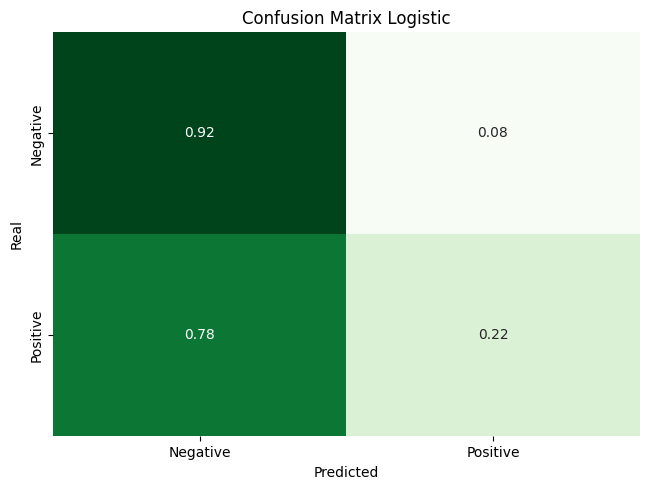

In [ ]:
matriz_confusion(y_pred, y_testl, "Logistic")

# **Precision, recall y f1-score: Reg. Logística**

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_testl, y_pred, target_names = ["Negative", "Positive"])
print(" My Model Metrics  ")
print(report)
correct=np.count_nonzero(y_pred == y_testl)

 My Model Metrics  
              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91       362
    Positive       0.26      0.22      0.24        45

    accuracy                           0.84       407
   macro avg       0.58      0.57      0.58       407
weighted avg       0.83      0.84      0.84       407



main

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

def kfold_cross_validation(X, y, k, alpha, num_iters):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        w = np.random.rand(X_train.shape[1])
        b = np.random.rand()
        #le mando train_log y luego predict
        w, b, _ = train_log(X_train, y_train, w, b, alpha, num_iters)
        y_pred = predict_log(X_test, w, b)

        # acurracy
        correct = np.count_nonzero(y_pred == y_test)
        accuracy = correct / len(y_test)
        accuracies.append(accuracy)

    # promedio
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy, accuracies

#pruebo para diferentes ks
listak=[]
listaaccuracy=[]
for i in range(5, 11):
  k = i  #
  listak.append(k)
  C = 1e6
  alpha = 1e-8
  epochs = 5000
  mean_accuracy, accuracies = kfold_cross_validation(x_train_resampled, y_train_resampled, k, alpha, epochs)
  listaaccuracy.append(mean_accuracy)
  print("K= ", i)
  print("K-Fold Cross-Validation Scores:", accuracies)
  print("Mean Accuracy:", mean_accuracy)


<ipython-input-16-e8c9c389b54c>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


K=  5
K-Fold Cross-Validation Scores: [0.5088757396449705, 0.5059171597633136, 0.5236686390532544, 0.5029585798816568, 0.42011834319526625]
Mean Accuracy: 0.49230769230769245
K=  6
K-Fold Cross-Validation Scores: [0.5283687943262412, 0.450354609929078, 0.5638297872340425, 0.5035460992907801, 0.47686832740213525, 0.47686832740213525]
Mean Accuracy: 0.4999726575974021
K=  7
K-Fold Cross-Validation Scores: [0.5330578512396694, 0.4380165289256198, 0.5454545454545454, 0.5352697095435685, 0.49377593360995853, 0.46887966804979253, 0.46887966804979253]
Mean Accuracy: 0.49761912926756385
K=  8
K-Fold Cross-Validation Scores: [0.5330188679245284, 0.4339622641509434, 0.5355450236966824, 0.5402843601895735, 0.5118483412322274, 0.4834123222748815, 0.5545023696682464, 0.47393364928909953]
Mean Accuracy: 0.5083133998032728
K=  9
K-Fold Cross-Validation Scores: [0.526595744680851, 0.4787234042553192, 0.4627659574468085, 0.574468085106383, 0.5053191489361702, 0.48936170212765956, 0.5212765957446809, 0.

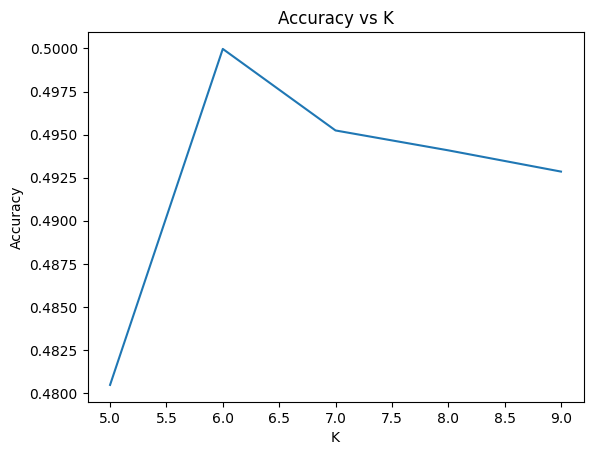

In [ ]:
import matplotlib.pyplot as plt

plt.plot(listak, listaaccuracy)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K')
plt.show()

# **Bootstrap: Reg. Logística**

<ipython-input-16-e8c9c389b54c>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Mean Accuracy: 0.5076
95.0% Confidence Interval: ConfidenceInterval(low=0.5068088390318347, high=0.5083644970414201)


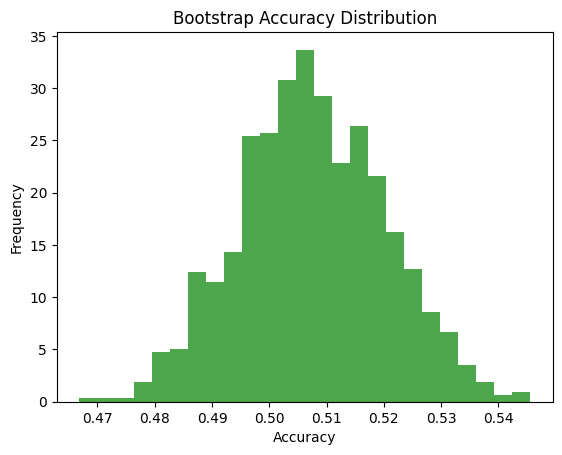

In [ ]:
import numpy as np
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

def accuracy_statistic(y_true, y_pred):
    correct = np.count_nonzero(y_true == y_pred)
    accuracy = correct / len(y_true)
    return accuracy

def bootstrap_resampling(X, y, w, b, n_resamples=1000, confidence_level=0.95):
    accuracies = []

    #
    for i in range(n_resamples):
        # uso np.random
        indices = np.random.choice(np.arange(len(y)), size=len(y), replace=True)
        X_sample = X[indices]
        y_sample = y[indices]

        # predicción con predict_log
        y_pred = predict_log(X_sample, w, b)

        #accuracy
        accuracy = accuracy_statistic(y_sample, y_pred)
        accuracies.append(accuracy)

    data = np.array(accuracies)
    res = bootstrap((data,), np.mean, confidence_level=confidence_level, random_state=42)


    print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
    print(f"{confidence_level*100}% Confidence Interval: {res.confidence_interval}")


    plt.hist(accuracies, bins=25, density=True, alpha=0.7, color='g')
    plt.title('Bootstrap Accuracy Distribution')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.show()

bootstrap_resampling(x_train_resampled, y_train_resampled, w, b)
